[View in Colaboratory](https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/Eager_Execution_Enabled.ipynb)

# Introduction 

Eager Execution (EE) enables you to run operations immediately. As we know in TensorFlow, you have to create a graph and run it within a session in order to execute the operations of the graph. On the other hand, EE enables you to run operations directly and inspect the output as the operations are executed. This is very useful especially for debugging. Moreover, EE is pythonic and intergrates pretty well with numpy so it makes programming really easy and flexible. The next version of TenosrFlow "2.0" will enable EE by default. 

From Google AI [article](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html), these are some benefits of using EE

   * Fast debugging with immediate run-time errors and integration with  python tools
   * Support for dynamic models using easy-to-use Python control flow
   * Strong support for custom and higher-order gradients
   * Almost all of the available TensorFlow operations
   
   ![alt text](https://i.imgur.com/YUlhihi.png)

# Enabling Eager Execution 
In current versions of TensorFlow eager execution is not enabled by default so you have to enable it. 

In [0]:
import tensorflow as tf

tf.enable_eager_execution()

Check if eager execution is enabled 

In [2]:
tf.executing_eagerly()

True

# Executing Ops Eagerly 
By perfoming operations you can see the output directly without creating a session. 

In [3]:
x = [[2.]]
m = tf.square(x)
print(m)

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


You can call `.numpy` to retrieve the results of the tensor as a numpy array

In [4]:
m.numpy()

array([[4.]], dtype=float32)

You can also compute an operation including two tensors 

In [5]:
a = tf.constant([[1, 2],
                 [3, 4]])

b = tf.constant([[2, 1],
                 [3, 4]])

ab = tf.matmul(a, b)

print('a * b = \n', ab.numpy())

a * b = 
 [[ 8  9]
 [18 19]]


# Constants and Variables 


*   `tf.constant`, creates a constant tensor populated with the values as argument. The values are immutable. 
*   `tf.Variable `, this method encapsultes a mutable tensor that can be changed later using assign 


Creating a constant tensor 

In [6]:
a = tf.constant([[2,3]])
print(a)

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)


A constant tensor is immutable so you cannot assign a new value to it.

In [7]:
try:
  a.assing([[3,4]])
except:
  print('Exception raised ')

Exception raised 


On the other hand variables are mutable and can be assigned a new value

In [8]:
v = tf.Variable(5.)

print('Old value for v =', v.numpy())
v.assign(2.)
print('New value for v =', v.numpy())

Old value for v = 5.0
New value for v = 2.0


You can also increment/decrement the value of a tensor 

In [9]:
v.assign(2.)
print('value     : ', v.numpy())
print('increment : ', tf.assign_add(v, 1).numpy())
print('decrement : ', tf.assign_sub(v, 1).numpy())

value     :  2.0
increment :  3.0
decrement :  2.0


You can return many information from a tensor variable, like the name, type , shape and what device it executes on. 

In [10]:
print('name  : ', v.name)
print('type  : ', v.dtype)
print('shape : ', v.shape)
print('device: ', v.device)

name  :  Variable:0
type  :  <dtype: 'float32'>
shape :  ()
device:  /job:localhost/replica:0/task:0/device:GPU:0


# Gradient Evaluation

Gradient evaluation is very importnat machine learning because it is based on function optimization. You can use `tf.GradientTape()` method to record the gradient of an arbitrary function

In [10]:
w = tf.Variable(2.0)

#watch the gradient of the loss operation
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(f'The gradient of w^2 at {w.numpy()} is {grad.numpy()}')

The gradient of w^2 at 2.0 is 4.0


You also compute the gradient directly using `gradients_function`. In this example we evaluate the gradient of the sigmoid function 

$$f(x) = \frac{1}{1+e^{-x}}$$

Note that 

$$f'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = f(x)(1-f(x)) $$

In [12]:
import tensorflow.contrib.eager as tfe 

def sigmoid(x):
  return 1/(1 + tf.exp(-x))

grad_sigmoid = tfe.gradients_function(sigmoid)

print('The gradient of the sigmoid function at 2.0 is ', grad_sigmoid(2.0)[0].numpy())

The gradient of the sigmoid function at 2.0 is  0.104993574


You can also compute higher order derivatives by nesting a gradient functions. For instance, 

$$f(x) = \log(x) , f'(x) = \frac{1}{x}, f''(x) = \frac{-1}{x^2}$$

In [14]:
dx = tfe.gradients_function

def log(x):
  return tf.log(x)

dx_log = dx(log)
dx2_log = dx(dx(log))
dx3_log = dx(dx(dx(log)))

print('The first  derivative of log at x = 1 is ', dx_log(1.)[0].numpy())
print('The second derivative of log at x = 1 is ', dx2_log(1.)[0].numpy())
print('The third  derivative of log at x = 1 is ', dx3_log(1.)[0].numpy())

The first  derivative of log at x = 1 is  1.0
The second derivative of log at x = 1 is  -1.0
The third  derivative of log at x = 1 is  2.0


# Custom Gradients

Some times the gradient is not what we want espeically if there is a problem in numerical instabilitiy. Consider the following function and its gradient 

$$f(x) = \log(1+e^x)$$

The gradient is 

$$f'(x) = \frac{e^x}{1+e^x}$$

Note that at big values of $x$ the gradient value will blow up.

In [15]:
def logexp(x):
  return tf.log(1 + tf.exp(x))
grad_logexp = tfe.gradients_function(logexp)

print('The gradient at x = 0  is ', grad_logexp(0.)[0].numpy())  

print('The gradient at x = 100 is ', grad_logexp(100.)[0].numpy()) 

The gradient at x = 0  is  0.5
The gradient at x = 100 is  nan


 We can revaluate the gradient by overriding the gradient of the function. We can recompute the gradient as 

$$f(x) =  \frac{1+e^x -e^x }{1+e^x} = 1 - \frac{1}{1 + e^{x}}$$

In [16]:
@tf.custom_gradient
def logexp_stable(x):
  e = tf.exp(x)
  #dy is optional, allows computation of vector jacobian products for vectors other than the vector of ones.
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.log(1 + e), grad

grad_logexp_stable = tfe.gradients_function(logexp_stable)

print('The gradient at x = 100 is ', grad_logexp_stable(100.)[0].numpy()) 

The gradient at x = 100 is  1.0


# Execution Callbacks

`add_execution_callback` can be used to monitor the execution of operations. These functions will be called when any function is executed eagerly. In this example we record the operation names.

In [16]:
#create a callback that records the operation name 
def print_op(op_type, op_name, attrs, inputs, outputs):
  print(op_type)
  
#clear previous callbacks
tfe.clear_execution_callbacks() 

#add the callback 
tfe.add_execution_callback(print_op)

#try runing an operation 
x = tf.pow(2.0, 3.0) - 3.0

#clear the callback 
tfe.clear_execution_callbacks() 

Pow
Sub


# Object Oriented Metrics
You can use `metrics` to record tensors/values and operate on them at the end. This is useful when recording the training history and you want to evaluate it at the end. Use `.result()` to evaluate the metric at the end. 

In [17]:
m = tfe.metrics.Mean("loss")

#record the loss 
m(2)
m(4)

print('The mean loss is ', m.result().numpy())

The mean loss is  3.0


If you want to remove the recorded values, you can reinstintiate the variables 

In [18]:
m.init_variables()
print('The mean loss is ', m.result().numpy())

The mean loss is  nan


# Linear Regression 

This example is refactored from https://www.tensorflow.org/guide/eager. We create a complete example of using linear regression to predict the paramters of the function 

$$f(x) = 3 x + 2 + noise$$

Given a point $x$ we want to predict the value of $y$. We train the model on 1000 data pairs $(x,f(x))$. 

The model to learn is a linear model 

$$\hat{y} = W x + b$$

Note that, we use `tf.GradientTape` to record the gradient with respect our trainable paramters.  

We MSE to calcuate the loss 

$$g = (y-\hat{y})^2$$

We use Gradient Descent to update the paramters 

$$W = W - \alpha  \frac{\partial g}{\partial W}$$

$$b = b - \alpha  \frac{\partial g}{\partial b}$$

In [19]:
#1000 data points 
NUM_EXAMPLES = 1000

#define inputs and outputs with some noise 
X = tf.random_normal([NUM_EXAMPLES])  #inputs 
noise = tf.random_normal([NUM_EXAMPLES]) #noise 
y = X * 3 + 2 + noise  #true output

#create model paramters with initial values 
W = tf.Variable(0.)
b = tf.Variable(0.)

#training info
train_steps = 200
learning_rate = 0.01

for i in range(train_steps):
  
  #watch the gradient flow 
  with tf.GradientTape() as tape:
    
    #forward pass 
    yhat = X * W + b
    
    #calcuate the loss (difference squared error)
    error = yhat - y
    loss = tf.reduce_mean(tf.square(error))
  
    #evalute the gradient with the respect to the paramters
    dW, db = tape.gradient(loss, [W, b])
  
    #update the paramters using Gradient Descent  
    W.assign_sub(dW * learning_rate)
    b.assign_sub(db* learning_rate)

    #print the loss every 20 iterations 
    if i % 20 == 0:
      print("Loss at step {:03d}: {:.3f}".format(i, loss))
      
print(f'W : {W.numpy()} , b  = {b.numpy()} ')

Loss at step 000: 14.478
Loss at step 020: 6.947
Loss at step 040: 3.632
Loss at step 060: 2.173
Loss at step 080: 1.531
Loss at step 100: 1.248
Loss at step 120: 1.124
Loss at step 140: 1.069
Loss at step 160: 1.045
Loss at step 180: 1.035
W : 2.9950246810913086 , b  = 1.9608360528945923 


# A Simple CNN

Here we create a simple convolutional neural network (CNN)to recognize hand-written digits (MNIST). We start by creating a simple alexnet CNN model. 

![alt text](https://i.imgur.com/twUKrlo.png)

In [0]:
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [0]:
def create_model():
  model = Sequential()
  model.add(Convolution2D(filters = 16, kernel_size = 3, padding = 'same', input_shape = [28, 28, 1], activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(BatchNormalization())
  model.add(Convolution2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(units = 100, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 10 , activation = 'softmax'))
  return model

## Create the model 

In [59]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
__________

Look at the output by frowarding a batch of zero images. 

In [60]:
import numpy as np
model(np.zeros((10, 28, 28, 1), np.float32))

<tf.Tensor: id=8234584, shape=(10, 10), dtype=float32, numpy=
array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)>

## Load MNIST dataset

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Look at the data

The label is  5


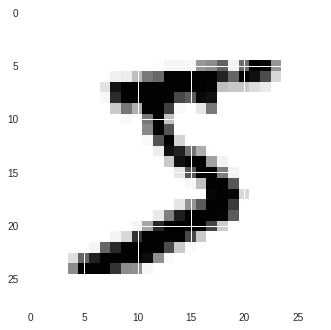

In [62]:
import matplotlib.pyplot as plt
print('The label is ',y_train[0])
plt.imshow(x_train[0])
plt.show()

## Preprcocessing the dataset 

In [0]:
import numpy as np

N = x_train.shape[0]

#normalization and convert to batch input 
x_train = tf.expand_dims(np.float32(x_train)/ 255., 3)
x_test  = tf.expand_dims(np.float32(x_test )/ 255., 3)

#one hot encoding
y_train = tf.one_hot(y_train, 10)
y_test  = tf.one_hot(y_test , 10)

## Get Random Batch

In [0]:
import numpy as np
def get_batch(batch_size = 32):
  r = np.random.randint(0, N-batch_size)
  return x_train[r: r + batch_size], y_train[r: r + batch_size]

## Design the loss function, Gradient and Accuracy metric

In [0]:
#evaluate the loss
def loss(model, x, y):
  prediction = model(x)
  return tf.losses.softmax_cross_entropy(y, logits=prediction)

#record the gradient with respect to the model variables 
def grad(model, x, y):
  with tf.GradientTape() as tape:
    loss_value = loss(model, x, y)
  return tape.gradient(loss_value, model.variables)

#calcuate the accuracy of the model 
def accuracy(model, x, y):
  
  #prediction
  yhat = model(x)
  
  #get the labels of the predicted values 
  yhat = tf.argmax(yhat, 1).numpy()
  
  #get the labels of the true values
  y    = tf.argmax(y   , 1).numpy()
  return np.sum(y == yhat)/len(y)

## Intitalize the variables

In [0]:
i = 1 

batch_size = 64 
epoch_length = N // batch_size
epoch = 0 
epochs = 5 

#use Adam optimizer 
optimizer = tf.train.AdamOptimizer()

#record epoch loss and accuracy  
loss_history = tfe.metrics.Mean("loss")
accuracy_history = tfe.metrics.Mean("accuracy")

## Training

In [68]:
while epoch < epochs:
  #get next batch
  x, y = get_batch(batch_size = batch_size)

  # Calculate derivatives of the input function with respect to its parameters.
  grads = grad(model, x, y)

  # Apply the gradient to the model
  optimizer.apply_gradients(zip(grads, model.variables),
                            global_step=tf.train.get_or_create_global_step())
  
  #record the current loss and accuracy   
  loss_history(loss(model, x, y))
  accuracy_history(accuracy(model, x, y))
  
  if i % epoch_length == 0:
    print("epoch: {:d} Loss: {:.3f}, Acc: {:.3f}".format(epoch, loss_history.result(), accuracy_history.result()))
    
    #clear the history 
    loss_history.init_variables()
    accuracy_history.init_variables()
    
    epoch += 1
    
  i += 1

epoch: 0 Loss: 1.548, Acc: 0.922
epoch: 1 Loss: 1.484, Acc: 0.979
epoch: 2 Loss: 1.478, Acc: 0.985
epoch: 3 Loss: 1.474, Acc: 0.988
epoch: 4 Loss: 1.472, Acc: 0.990


## Testing

In [69]:
accuracy(model, x_test, y_test)

0.986

# Save and Restore a Model
You can save training history then restore it later. 

In [70]:
#create a directory for saving the model
import os 
checkpoint_dir = 'model'
os.mkdir(checkpoint_dir)

#create a root for the checkpoint
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model,
                           optimizer_step=tf.train.get_or_create_global_step())

#save the model 
root.save(file_prefix=checkpoint_prefix)

'model/ckpt-1'

Restore the model 

In [71]:
#create an empty model 
model = create_model()

#accuracy of the empty model 
print('accuracy before retrieving the model ',accuracy(model, x_test, y_test))

#create a checkpoint variable 
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=create_model(),
                           optimizer_step=tf.train.get_or_create_global_step())

#restore the model
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

#retrieve the trained model 
model = root.model 

print('accuracy after retrieving the model ',accuracy(model, x_test, y_test))

accuracy before retrieving the model  0.096
accuracy after retrieving the model  0.986


# Forget about Graphs ? 

While eager execution makes development and debugging more interactive, TensorFlow graph execution has advantages for distributed training, performance optimizations, and production deployment. However, writing graph code can feel different than writing regular Python code and more difficult to debug.

For building and training graph-constructed models, the Python program first builds a graph representing the computation, then invokes Session.run to send the graph for execution on the C++-based runtime. This provides:

* Automatic differentiation using static autodiff.
* Simple deployment to a platform independent server.
* Graph-based optimizations (common subexpression elimination, constant-folding, etc.).
* Compilation and kernel fusion.
* Automatic distribution and replication (placing nodes on the distributed system).
Deploying code written for eager execution is more difficult: either generate a graph from the model, or run the Python runtime and code directly on the server.